# Experiment-3: AdaBoost for face classification and Open-CV for face detection 
## In this experiment, we will: 
- (1) Get more intuitions about AdaBoost. 
- (2) Get your hands dirty on self-constructed face/non-face dataset, which contains 500 256x256 face images and 500 32x32 non-face images. 
- (3) Get some experience about weak learner's performance effect and number of weak learner exploration.
- (4) Use Open-CV library for face detection.  
### As usual, in this experiment, we will use the mini framework [simple_ml](https://github.com/lizhaoliu-Lec/simple_ml). Besides, we will use sklearn's DecisionTreeClassifier (DTC) as weak learner.

In [5]:
# as usual, do a little setup
%pip install simple_ml
import os
import random
import pickle
import numpy as np

from tqdm import tqdm
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from simple_ml.preprocessing import NPDFeature
from simple_ml.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def accuracy(y_t, y_pred):
    y_pred = y_pred.reshape((-1, 1))
    return np.mean(y_t == y_pred)

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load the data.

def convert_data_to_npd_feats(data_path='..\\tmp\\exp3', size=24, val_split=0.1, test_split=0.2, seed=1234):
    face_img_root = os.path.join(data_path, 'face')
    non_img_root = os.path.join(data_path, 'nonface')
    faces_img_paths = os.listdir(face_img_root)
    non_img_paths = os.listdir(non_img_root)
    faces_img_paths = [os.path.join(face_img_root, i) for i in faces_img_paths]
    non_img_paths = [os.path.join(non_img_root, i) for i in non_img_paths]

    root_name = 'x'.join([str(size), str(size)])
    root_name = 'npd_' + root_name
    root_path = os.path.join(data_path, root_name)
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    all_Xy_data_path = os.path.join(root_path, 'data.bin')

    if not os.path.exists(all_Xy_data_path):
        # get face images
        face_imgs = []
        for face_img in tqdm(faces_img_paths):
            im = Image.open(face_img, mode='r').convert('L')
            im = im.resize((size, size), Image.ANTIALIAS)
            im = np.asarray(im)
            npd = NPDFeature(image=im)
            im = npd.extract()
            face_imgs.append(im)
        face_arrays = np.array(face_imgs)
        face_labels = np.ones((face_arrays.shape[0], 1))
        # get non face images
        non_imgs = []
        for non_img in tqdm(non_img_paths):
            im = Image.open(non_img, mode='r').convert('L')
            im = im.resize((size, size), Image.ANTIALIAS)
            im = np.asarray(im)
            npd = NPDFeature(image=im)
            im = npd.extract()
            non_imgs.append(im)
        non_arrays = np.array(non_imgs)
        non_labels = -1 * np.ones((non_arrays.shape[0], 1))

        X = np.concatenate([face_arrays, non_arrays], axis=0)
        y = np.concatenate([face_labels, non_labels], axis=0)

        rand_idx = [_ for _ in range(X.shape[0])]
        random.seed(seed)
        random.shuffle(rand_idx)
        X = X[rand_idx]
        y = y[rand_idx]
        total_size = X.shape[0]
        train_size = int(total_size * (1 - val_split - test_split))
        val_size = train_size + int(total_size * val_split)
        X_train, y_train = X[:train_size] / 255.0, y[:train_size]
        X_val, y_val = X[train_size:val_size] / 255.0, y[train_size:val_size]
        X_test, y_test = X[val_size:] / 255.0, y[val_size:]
        pickle.dump([X_train, y_train, X_val, y_val, X_test, y_test],
                    file=open(all_Xy_data_path, mode='wb'))
    else:
        X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(file=open(all_Xy_data_path, mode='rb'))
    print('X train: ', X_train.shape, ' y train: ', y_train.shape)
    print('X val: ', X_val.shape, ' y val: ', y_val.shape)
    print('X test: ', X_test.shape, ' y test: ', y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = convert_data_to_npd_feats()
print('We have `%d` training examples, `%d` validation examples and `%d` test examples' % (X_train.shape[0], X_val.shape[0],X_test.shape[0]))
print('X_train shape: ', X_train.shape, ', X_val shape: ', X_val.shape, ', X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape, ', y_val shape: ', y_val.shape, ', y_test shape: ', y_test.shape)

X train:  (700, 165600)  y train:  (700, 1)
X val:  (100, 165600)  y val:  (100, 1)
X test:  (200, 165600)  y test:  (200, 1)
We have `700` training examples, `100` validation examples and `200` test examples
X_train shape:  (700, 165600) , X_val shape:  (100, 165600) , X_test shape:  (200, 165600)
y_train shape:  (700, 1) , y_val shape:  (100, 1) , y_test shape:  (200, 1)


We show the error rate to alpha in adaboost. 
We can see that, as the error rate goes up, alpha goes down.


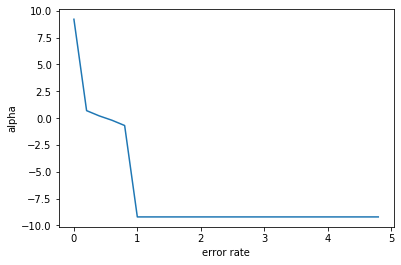

In [3]:
def error_to_alpha(x, eps=1e-8):
    x = x.clip(min=eps, max=1-eps)
    return 0.5 * np.log(1/x - 1)

z = np.arange(1e-8, 5, 0.2)
e = error_to_alpha(z)
plt.plot(z, e)
plt.xlabel('error rate')
plt.ylabel('alpha')
# plt.savefig('loss_fn.png', dpi=300)
plt.show()


### Weak learner's Performance

We first evaluate the weak learner's performance with different depth in DTC.

we search depth in range(5) and validate the performance on validation set.

********** begin with depth = 1 **********
********** begin with depth = 2 **********
********** begin with depth = 3 **********
********** begin with depth = 4 **********
********** begin with depth = 5 **********


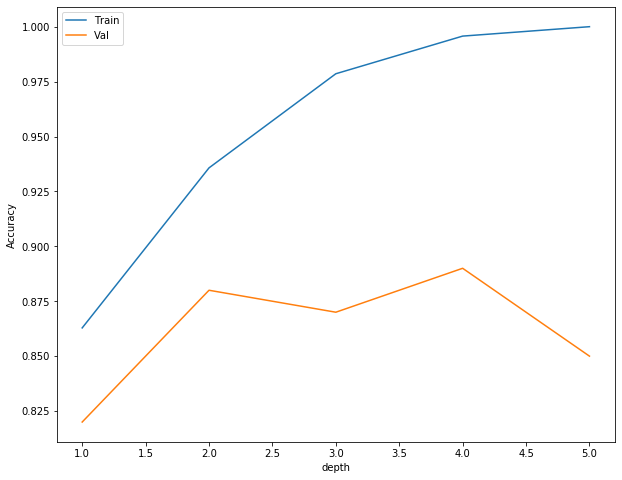

In validation set, best depth: 4, best accuracy: 0.8900


In [6]:
depths = [1, 2, 3, 4, 5]
d2train_acc = []
d2val_acc = []

for d in depths:
    print(10*'*' + ' begin with depth = %d ' % d + 10*'*')
    weak = DecisionTreeClassifier(max_depth=d)
    weak.fit(X_train, y_train)
    y_val_pred = weak.predict(X_val)
    y_train_pred = weak.predict(X_train)
    d2train_acc.append(accuracy(y_train, y_train_pred))
    d2val_acc.append(accuracy(y_val, y_val_pred))

plt.plot(depths, d2train_acc, label='Train')
plt.plot(depths, d2val_acc, label='Val')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.savefig('d_weak_acc.png', dpi=300)
plt.show()

max_idx = np.argmax(np.array(d2val_acc))
print('In validation set, best depth: %d, best accuracy: %.4f' % (depths[max_idx], d2val_acc[max_idx]) )
